# Acoustic Dataset Usage Example

This notebook demonstrates how to use the refactored `ShuffledAcousticDataset` class with the new preprocessing function.

In [1]:
import sys
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import torch

# Add the project root to the Python path to import the acoustic_no module
sys.path.append('..')

from acoustic_no.data import preprocess_acoustic_dataset, ShuffledAcousticDataset

## Step 1: Preprocessing the Dataset

First, we'll preprocess the raw dataset into a format that can be efficiently loaded by the `ShuffledAcousticDataset` class.

In [2]:
# Define paths for raw and processed data
raw_data_dir = pathlib.Path('../resources/dataset/small_dataset/training')
processed_data_dir = pathlib.Path('.temp/processed')

# Create the processed data directory if it doesn't exist
processed_data_dir.mkdir(parents=True, exist_ok=True)

# Set preprocessing parameters
num_chunks = 8  # Use a small number for demonstration purposes
samples_per_scene = 16  # Number of samples per chunk
depth = 8

# Process the data (comment this out if you've already run it once)
preprocess_acoustic_dataset(
    data_dir=raw_data_dir,
    output_dir=processed_data_dir,
    num_chunks=num_chunks,
    samples_per_scene=samples_per_scene,
    depth=depth
)

Processing chunks:   0%|          | 0/8 [00:00<?, ?it/s]

Processing chunks: 100%|██████████| 8/8 [00:21<00:00,  2.71s/it]


## Step 2: Loading the Preprocessed Dataset

Now we'll load the preprocessed dataset using the new `ShuffledAcousticDataset` class.

In [3]:
# Load the dataset
dataset = ShuffledAcousticDataset(dataset_dir=processed_data_dir, samples_per_scene=samples_per_scene)

print(f"Dataset size: {len(dataset)}")
print(f"Depth: {dataset.depth}")
print(f"Number of chunks: {dataset.num_chunks}")
print(f"Number of scenes: {dataset.num_scenes}")

Dataset size: 1024
Depth: 8
Number of chunks: 8
Number of scenes: 8


## Step 3: Accessing Data Samples

Let's retrieve and visualize some sample data.

In [4]:
# Get a sample from the dataset
sample_idx = 0
sample = dataset[sample_idx]

# Extract the components
x = sample['x']
y = sample['y']
v = sample['v']
a = sample['a']

print(f"Input shape: {x.shape}")
print(f"Output (pressure) shape: {y.shape}")
print(f"Velocity shape: {v.shape}")
print(f"Alpha shape: {a.shape}")

Input shape: torch.Size([25, 64, 64])
Output (pressure) shape: torch.Size([8, 64, 64])
Velocity shape: torch.Size([16, 64, 64])
Alpha shape: torch.Size([8, 64, 64])


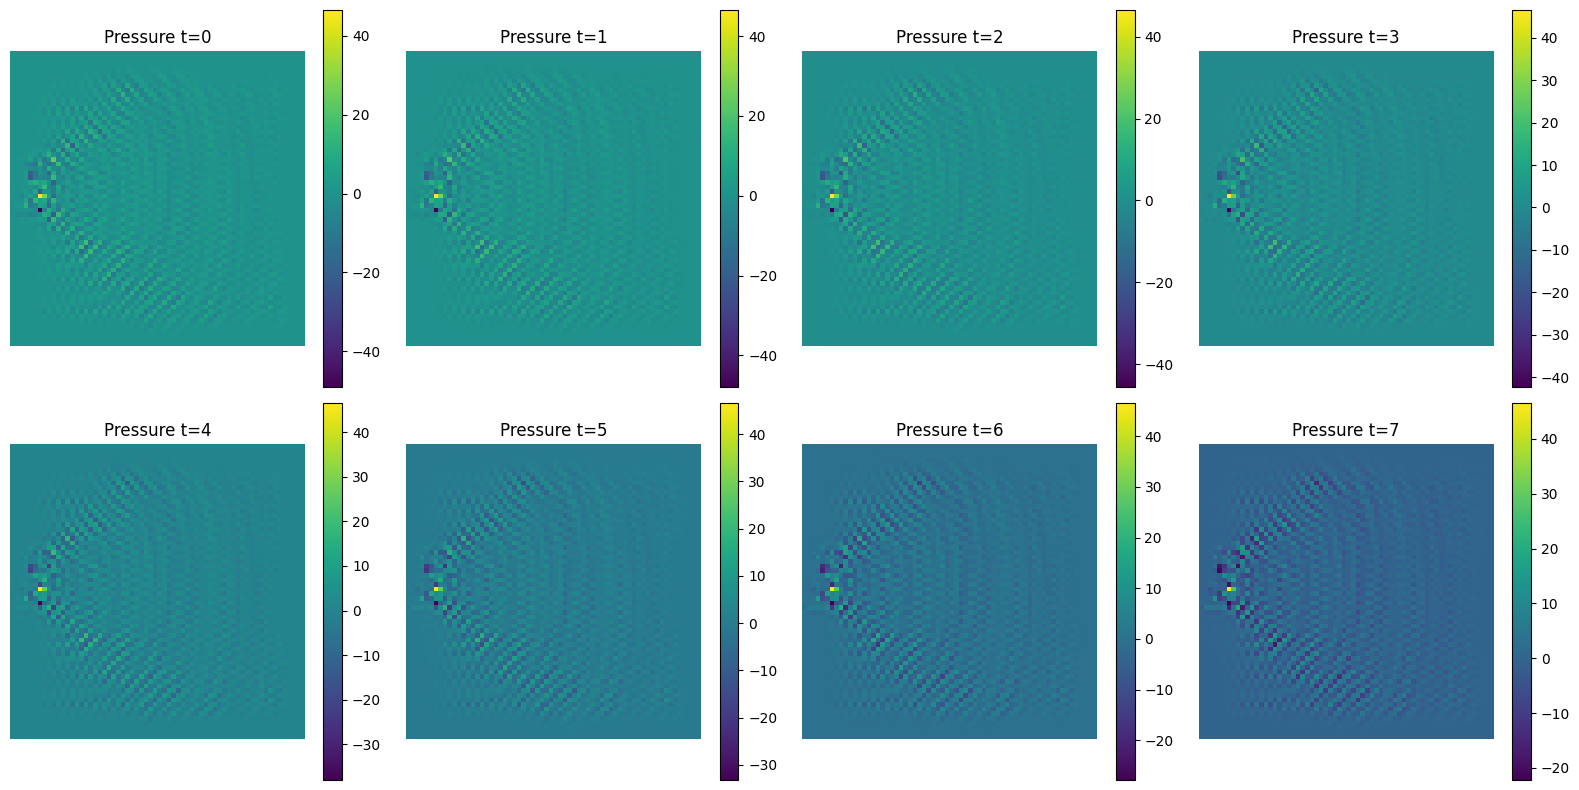

In [5]:
# Visualize the pressure field at different time steps
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(min(8, y.shape[0])):
    ax = axes[i]
    im = ax.imshow(y[i].numpy(), cmap='viridis')
    ax.set_title(f"Pressure t={i}")
    ax.axis('off')
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

## Step 4: Creating a DataLoader for Training

Now let's create a DataLoader that could be used for training a model.

In [6]:
from torch.utils.data import DataLoader, Subset

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset = Subset(dataset, range(train_size))
val_dataset = Subset(dataset, range(train_size, len(dataset)))

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Create data loaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Get a batch from the train_loader
batch = next(iter(train_loader))
print(f"Batch x shape: {batch['x'].shape}")
print(f"Batch y shape: {batch['y'].shape}")

Training set size: 819
Validation set size: 205
Batch x shape: torch.Size([4, 25, 64, 64])
Batch y shape: torch.Size([4, 8, 64, 64])


In [7]:
%timeit next(iter(train_loader))

940 μs ± 1.71 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
it = iter(train_loader)
def get_next_batch(it):
    try:
        return next(it)
    except StopIteration:
        it = iter(train_loader)
        return next(it)

In [9]:
%timeit get_next_batch(it)

The slowest run took 4.74 times longer than the fastest. This could mean that an intermediate result is being cached.
1.49 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
